# This is the main function for Emotion Forecasting Project. 

### Part 1 : Prepare the dataset
The first step is to have the audio-visual features from the IEMOCAP dataset. We have the facial-video features available from IEMOCAP dataset. But we need to extract audio features. The skeleton code `audio_feat.praat` does the job.

The next step is to call different function from our classes to prepare the dataset from raw data

In [20]:
from Codes.combine_audiovisual_data import combining_AV
from Codes.window_based_reformation import window_based_reformation
from Codes.Utt_Fore_Data_Prep import Prepare_UF_Cur_Data, Prepare_UF_history_Data
from Codes.run_algorithms import run_deep_learning

First, we will combine the audio-visual features.

The audio and visual features are not extracted in a same framerate. We have to do the following things:
1. remove the `nan` features from video datasets
2. Downsample the video features to make it as a same length as the audio features.

The following code will do that:

In [11]:
Combining_data = combining_AV('Files/audio_features', 'Files/video_features', "Files/sameframe")
Combining_data.produce_speakerwise_AV_data()

Next, to use the sequential information of the audio-visual cues, we will create overlapped frames. These frames will have statistical information which will be used as features. So, the following code will do the tasks:

1. Create window based sequences
2. Find mean, standard deviation, first and third quantile, interquantile range of those windows.

In [13]:
Windowing = window_based_reformation('Files/sameframe')
Windowing.process_data(window_type='dynamic') 
#important note: setting the window_type as 'static' will stop creating any window based features and create statistical features
#from the whole sequence. We will use them to make a FC-DNN based model.

After that, we prepare the dataset for utterance forecasting. The code is so designed that you can have any `step` of utterance forecasting. The code does the followign task:

1. Process the `IEMOCAP_EmoEvaluation.txt` file and produces a smart look-up table for finding the time-distances for Utterance Forecasting.
2. Create the dataset, normalize (or without normalize) it, and add zero padding at the end. The utterance length have variations and thus, the functions add zero (zero-padding) to make it of same length. 

In [14]:
UF_cur = Prepare_UF_Cur_Data()
UF_cur.creating_dataset(step=1, feature_type='dynamic', normalization=True)
#Set any number of step. set normalization 'False' to not normalize the file. 
#If set 'True', it will produce speaker-wise z-normalization.

Next, we will create Utterance forecasting dataset with `History` information. 

In [15]:
UF_his = Prepare_UF_history_Data()
UF_his.creating_dataset(step=1, feature_type='dynamic', normalization=True)

### Part 2 : Run the models

For running the sequential models, we use `LSTM` or `BLSTM`. Next chunk of code will create a model and run the forecasting task.
The code serves following task:

1. Prepare the feature matrix , label vector for emotion forecasting task using LSTM or BLSTM.
2. If the model_type is selected as `unidirectional`, we will have regular LSTM cell, if set to `bidirectional`, BLSTM layers will be set. 

In [21]:
forecast = run_deep_learning()
features, label, speaker_group = forecast.prepare_data(directory='Files/UF_His_data/step_1', feature_type='dynamic') #Change the file location accordingly
Ground_Truth, Prediction, Probability = forecast.LSTM(features, label, speaker_group, model_type='unidirectional') #if model_type set to bidirectional, it will be BLSTM

### Part 3 : The model performance

#### Part 3.1: The confusion matrix
Now, we'd like to take a look, how the confusion matrix look like for all the 10 speaker cases for Utterance Forecasting with history and step 1. First, we want to create a function for observing the confusion matrix.

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
def confusion_matrix_plot(speaker, y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    
    """
    This function will create a plot of confusion matrix and also show of per class performance
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix for speaker {}'.format(speaker)
        else:
            title = 'Confusion matrix, without normalization for speaker {}'.format(speaker)
    cm = confusion_matrix(y_true, y_pred)
    


    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, 2)


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Forecasted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

If we donot want the normalized confusion matrix:

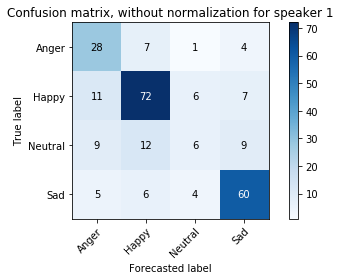

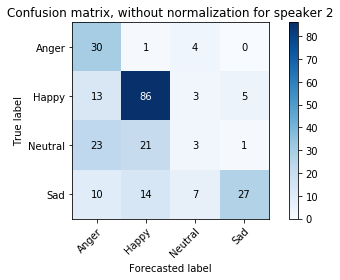

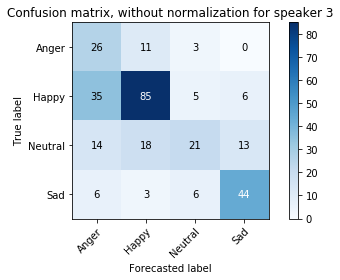

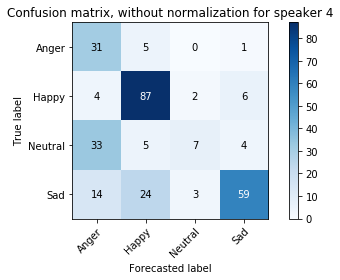

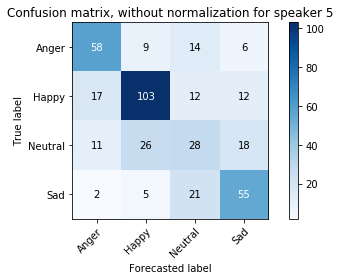

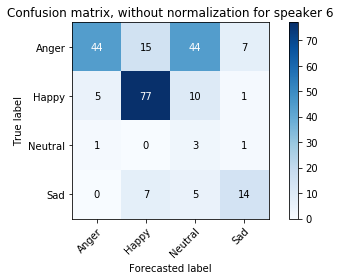

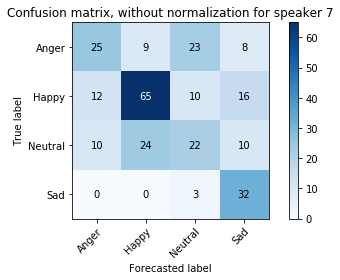

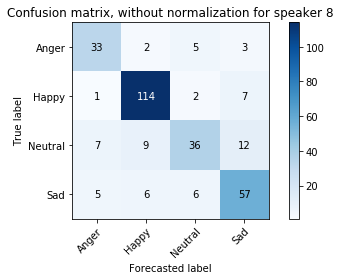

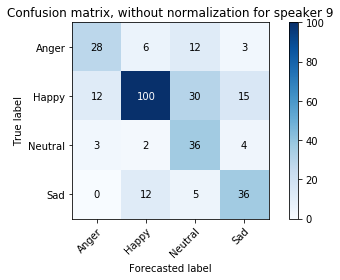

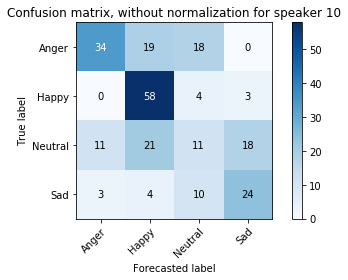

In [39]:
for i in range(10):
    confusion_matrix_plot(i+1, Ground_Truth[i], Prediction[i], ['Anger', 'Happy', 'Neutral', 'Sad'], normalize=False)

But if we want a normalized version, we get the following

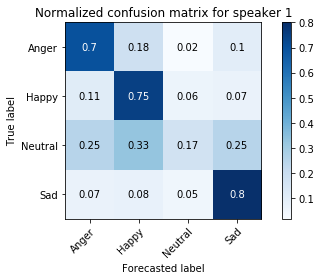

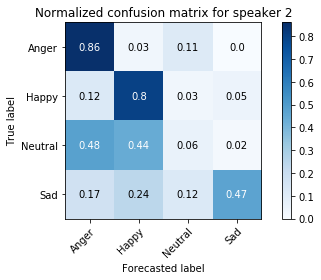

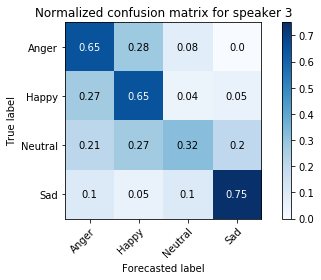

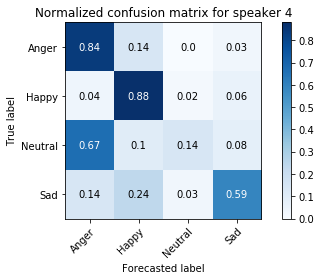

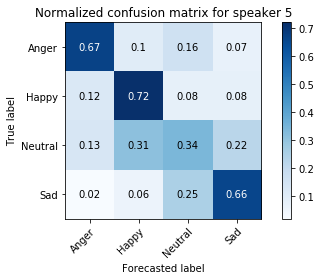

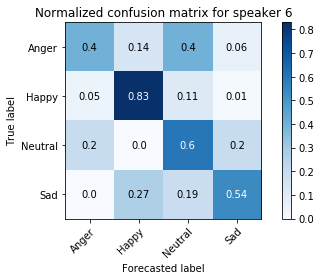

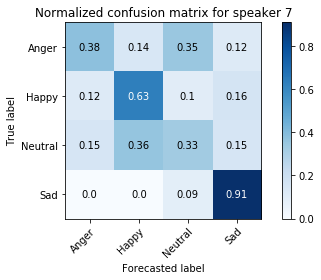

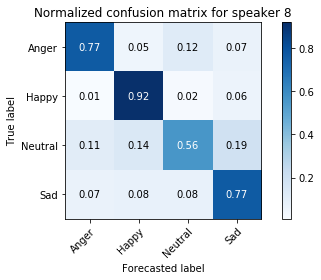

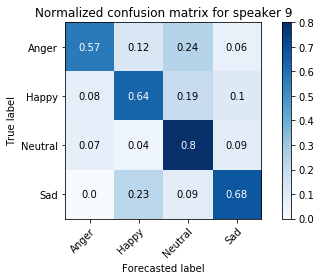

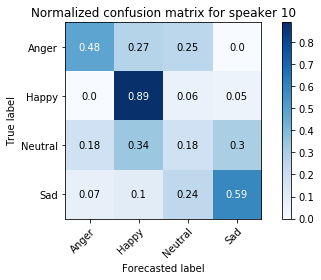

In [41]:
for i in range(10):
    confusion_matrix_plot(i+1, Ground_Truth[i], Prediction[i], ['Anger', 'Happy', 'Neutral', 'Sad'], normalize=True)
    

It seems that performances are not consistent for all the emotion class. For example, Neutral emotion performs poorly for all speakers. For better visulization, we will put all the data together and visualize the emotion specific performance.

In [42]:
All_Ground_Truth = [] 
All_Prediction = []
for speakers in range(1, 11):
    All_Ground_Truth = All_Ground_Truth + Ground_Truth[speakers-1]
    All_Prediction = All_Prediction + Prediction[speakers-1]

In terms of confusion matrix, this is what we get:

Confusion matrix for all speaker is 
 [[337  84 124  32]
 [110 847  84  78]
 [122 138 173  90]
 [ 45  81  70 408]]


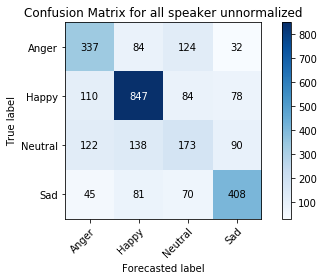

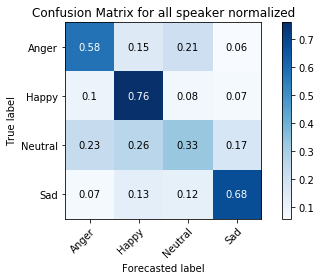

In [51]:
print('Confusion matrix for all speaker is \n {}'.format(confusion_matrix(All_Ground_Truth, All_Prediction)))
confusion_matrix_plot(None, All_Ground_Truth, All_Prediction, ['Anger', 'Happy', 'Neutral', 'Sad'], 
                      title = 'Confusion Matrix for all speaker unnormalized', normalize=False)
confusion_matrix_plot(None, All_Ground_Truth, All_Prediction, ['Anger', 'Happy', 'Neutral', 'Sad'], 
                      title = 'Confusion Matrix for all speaker normalized', normalize=True)


#### Part 3.2: The Unweighted Recall Performance


Now, in the affective computing community, as a result matrix, Unweighted Average Reall is the most widely accepted one. The recall is:   $\frac{true\_positive}{true\_positive + false\_negative}$

Averagor or Unweighted (UAR) Recall calculates the recall of our four emotion class and thus the result is free of bias toward the group having most data (i.e., the emotion group with most data). 

In [68]:
from sklearn.metrics import recall_score

UAR = {}
Mean_UAR = 0
for speaker in range(1, 11):
    UAR[speaker] = recall_score(Ground_Truth[speaker-1], Prediction[speaker-1], average='macro')
    Mean_UAR = Mean_UAR + UAR[speaker] 
    
print('The average Unweighted Recall across all 10 speakers is {0:.2f}%'.format(Mean_UAR*100/10))

The average Unweighted Recall across all 10 speakers is 60.68%


Let's get a speaker specific view:

First, we will make a function for that so that in future we can use the function as well !

In [96]:
def horizontal_bar_plot(classes_list, accuracy_list, title=None, x_label=None, y_label=None):
    '''
    The function takes input of accracy or any performance matrices for the group of data. It outputs the
    horizontal bar
    '''
    fig, ax = plt.subplots()
    y_position = np.arange(len(classes_list))
    ax.barh(y_position, accuracy_list, align='center')
    ax.set_yticks(y_position)
    ax.set_yticklabels(classes_list)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

    plt.show()

In [97]:
list_of_speakers = ['Speaker_{}'.format(sp) for sp in range(1, 11)]
accuracy_list = [UAR[sp] for sp in range(1, 11)]

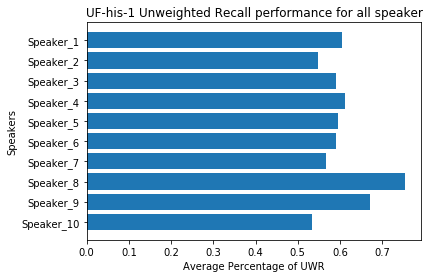

In [98]:
horizontal_bar_plot(list_of_speakers, accuracy_list, 'UF-his-1 Unweighted Recall performance for all speaker', 'Average Percentage of UWR', 'Speakers')

#### Part 3.2: Time-distance based performance


Now, we will try to visualize the time-distances for our 1-step utterance forecasting.

In [217]:
import pandas as pd
#for speaker 1
forcasting_table = pd.read_pickle('Files/UF_Cur_data/step_1/audio_visual_speaker_1.csv')

In [106]:
forcasting_table.head(10)

,cuurent_name,features,UF_label,forecasted_utt_name,time_distance
0,Ses01F_impro01_F000,"[[-0.663651085378874, -0.8083824113882162, -0....",2,Ses01F_impro01_F001,3.43835
1,Ses01F_impro01_F001,"[[-0.5335064788213841, 0.2782760966066148, -1....",2,Ses01F_impro01_F002,5.75110
2,Ses01F_impro01_F004,"[[0.27343196843332535, 0.9118952476315478, -1....",2,Ses01F_impro01_F005,6.44215
3,Ses01F_impro01_F011,"[[0.35660796974137554, 0.23457097629413617, -0...",0,Ses01F_impro01_F012,9.29000
4,Ses01F_impro01_F013,"[[1.8492049223413494, 0.8803573845094621, -0.3...",2,Ses01F_impro01_F014,5.07910
5,Ses01F_impro02_F000,"[[-0.021553624478081318, -0.398316454522779, -...",3,Ses01F_impro02_F001,9.38060
6,Ses01F_impro02_F001,"[[-0.1102143720984548, -0.8385940529804035, 0....",3,Ses01F_impro02_F002,8.11270
7,Ses01F_impro02_F002,"[[2.571224609487314, -1.443966632779894, 0.287...",2,Ses01F_impro02_F003,5.70605
8,Ses01F_impro02_F003,"[[1.6810782797126154, -1.4901671688418237, 0.0...",3,Ses01F_impro02_F004,15.09125
9,Ses01F_impro02_F004,"[[0.23806824540224464, -1.6012305998329044, -1...",3,Ses01F_impro02_F005,9.80500


Let's put all the **time distances** togteher

In [108]:
time_distances = []
for speaker in range(1, 11):
    time_distances = time_distances+ pd.read_pickle('Files/UF_Cur_data/step_1/audio_visual_speaker_{}.csv'.format(speaker))['time_distance'].tolist()

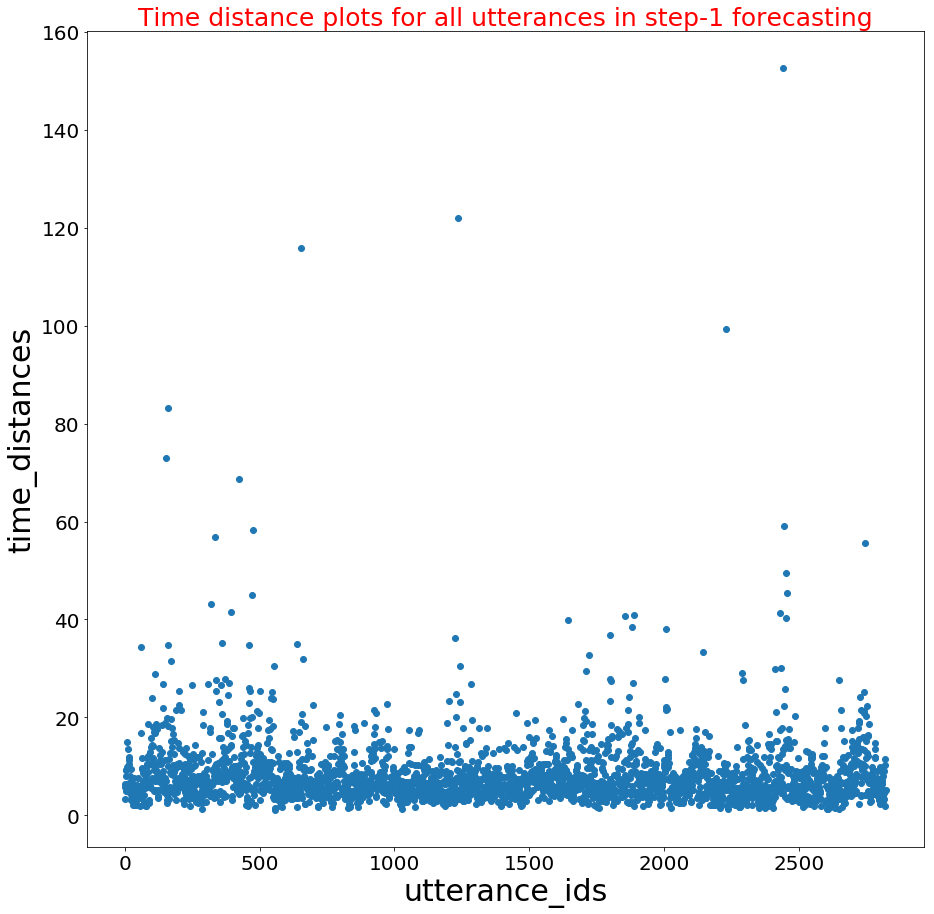

In [192]:
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(list(range(len(time_distances))), time_distances)
ax.set_ylabel('time_distances', fontsize=30)
ax.set_xlabel('utterance_ids', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_title('Time distance plots for all utterances in step-1 forecasting', fontsize=25, color='r')
plt.show()

The plot shows that most of the time distances lie between 0 to 20 second. But it has high variation. We will use a boxplot to have a better visualization.

**So, without the outliers**

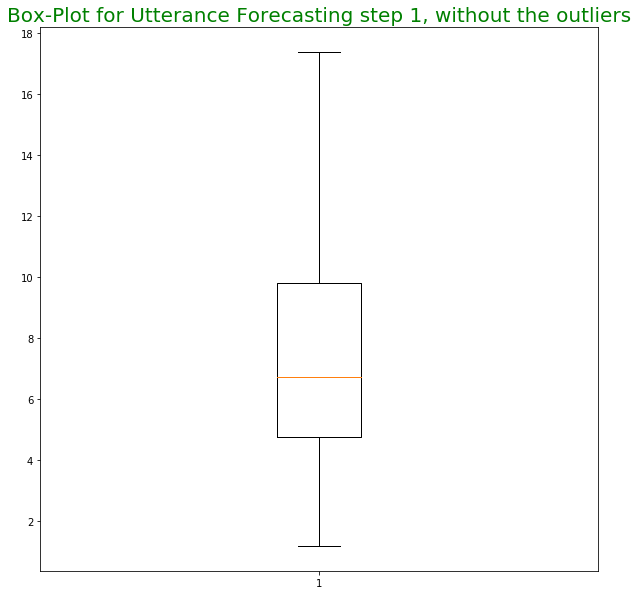

In [197]:
fig, ax = plt.subplots(figsize=(10,10))
box_plot_noOutlier=ax.boxplot(time_distances, 0, '')
Z = ax.set_title('Box-Plot for Utterance Forecasting step 1, without the outliers', fontsize=20, color='g')
plt.show()

We will approximate three sets of time-frame and find our forecasting performance based on that:
    1. Time Group 1 : From more than 1 second to less or equal 5 second
    2. Time Group 2 : From more than 5 second to less or equal 10 second
    3. Time Group 3 : From more than 10 second to less or equal 18 second

In [177]:
TG_index = {}
TG_index[1] = [index for index, time in enumerate(time_distances) if time>0 and time<6]
TG_index[2] = [index for index, time in enumerate(time_distances) if time>6 and time<12]
TG_index[3] = [index for index, time in enumerate(time_distances) if time>12 and time<18]

In [189]:
GT_timewise= {}
Pred_timewise = {}
for time_group in [1, 2, 3]:
    GT_timewise[time_group] = [All_Ground_Truth[i] for i in TG_index[time_group]]
    Pred_timewise[time_group] = [All_Prediction[i] for i in TG_index[time_group]]
    RECALL =  recall_score(GT_timewise[time_group],  Pred_timewise[time_group], average='macro')
    print('Performance for group {0} is {1:.2f}%'.format(time_group, RECALL*100))
    

Performance for group 1 is 58.96%
Performance for group 2 is 58.43%
Performance for group 3 is 57.85%


**Although how the time should be divided, can be an interesting research question, the manual grouping shows that performance declines slightly with increase in time.**

Now, we will create the boxplot for Utterance Forecasting step 1, 2, and 3

In [216]:
All_time_distances = {} 
for step in [1, 2, 3]:
    time_distances = []
    for speaker in range(1, 11):
        time_distances = time_distances+ pd.read_pickle('Files/UF_Cur_data/step_{}/audio_visual_speaker_{}.csv'.format(step, speaker))['time_distance'].tolist()
    All_time_distances[step] = time_distances

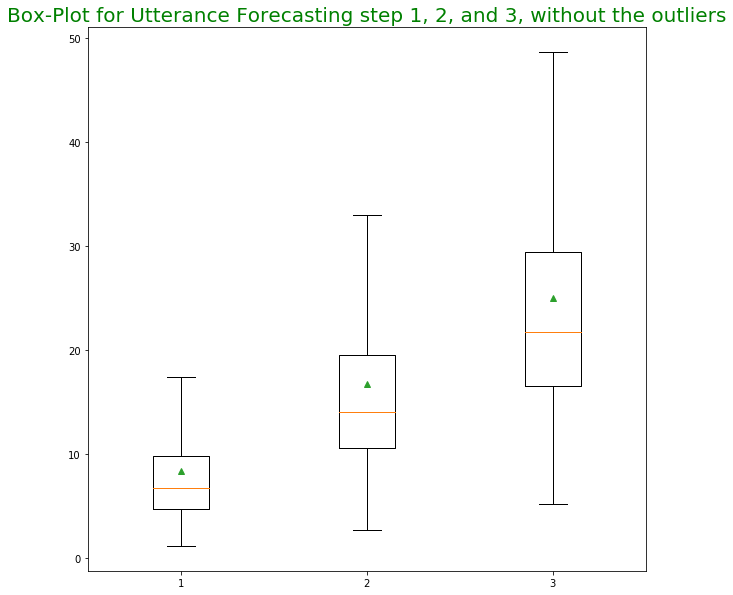

In [215]:
fig, ax = plt.subplots(figsize=(10,10))
box_plot_noOutlier=ax.boxplot([All_time_distances[1], All_time_distances[2], All_time_distances[3]], 0, '', showmeans=True)
ax.set_title('Box-Plot for Utterance Forecasting step 1, 2, and 3, without the outliers', fontsize=20, color='g')
plt.show()

The box plots perfectly depicts that, more we increase the step numbers, higher the average time distance will be. However, it also indicates the higher standard deviation with increase in utterance step. This phenomena raises many important research directions.

1. What is the ideal 'forecasting window' ?
2. How long we can perform forecasting effectively ? 
3. Does emotion follow any timely pattern ? 

The questions will remain open for further research. 